"""
==============================================================================
01 - EXPLORATORY DATA ANALYSIS (EDA)
==============================================================================

PURPOSE OF THIS NOTEBOOK:
-------------------------
Before building any machine learning model, we MUST understand our data.
EDA helps us:
1. Verify data quality (no missing values, duplicates, or gaps)
2. Understand statistical properties (distributions, ranges, outliers)
3. Test assumptions (stationarity - crucial for time series)
4. Justify modeling approach (why classification, not regression?)
5. Analyze target variable (are labels balanced?)

This notebook answers the critical question:
"Is our data suitable for training a price direction classifier?"

WHAT YOU'LL LEARN:
------------------
- Bitcoin price data is NON-STATIONARY (can't use simple regression)
- Log returns ARE STATIONARY (suitable for ML features)
- Direct return prediction gives R² ≈ 0 (regression fails)
- Classification of direction is more achievable
- Oracle labels provide clean training targets

"""

# Bitcoin Price Direction Prediction - EDA

**Goal**: Understand our data before building models.

**Key Questions**:
1. Is the data clean? (no gaps, duplicates, missing values)
2. What are the statistical properties? (mean, std, distribution)
3. Is the price series stationary? (can we use regression?)
4. How are our target labels distributed? (balanced classes?)

In [34]:
# ==============================================================================
# IMPORTS AND SETUP
# ==============================================================================
# Why these imports?
# - pandas: Data manipulation and analysis
# - numpy: Numerical operations (log returns, etc.)
# - matplotlib/seaborn: Visualization
# - scipy.stats: Statistical tests (Q-Q plots)
# - statsmodels.adfuller: Augmented Dickey-Fuller test for stationarity

import sys
from pathlib import Path

# Add project root to Python path so we can import our modules
# This is needed because we're running from notebooks/ directory
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller
import warnings

# Suppress warnings for cleaner output (use with caution in production)
warnings.filterwarnings('ignore')

# Set visualization style - 'seaborn-v0_8-darkgrid' provides clean, readable plots
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)  # Default figure size
plt.rcParams['font.size'] = 11

In [35]:
# ==============================================================================
# LOAD DATA
# ==============================================================================
# 
# WHY: We need to load our preprocessed data to analyze it.
# 
# The load_and_merge_data() function:
# 1. Loads klines (OHLCV candlestick data)
# 2. Loads funding rates (market sentiment indicator)
# 3. Loads volume breakdown (buy/sell volumes)
# 4. Merges them all by timestamp
# 5. Creates log returns
#
# We use end_date='2025-12-31' because January 2026 data wasn't downloaded.

from src.data.loader import load_and_merge_data

print("Loading data...")
print("This combines klines, funding rates, and volume data into one DataFrame.")
print()

df = load_and_merge_data(end_date='2025-12-31')

print(f"\n✅ Data loaded successfully!")
print(f"Shape: {df.shape} (rows, columns)")
print(f"Date range: {df['time'].min()} to {df['time'].max()}")
print(f"Columns: {df.columns.tolist()}")

Loading data...
This combines klines, funding rates, and volume data into one DataFrame.


📥 LOADING DATA

1️⃣ Loading klines...
   Loaded 70,752 rows

2️⃣ Loading funding rates...
   Merged funding rates

3️⃣ Loading volume breakdown...
   Merged volume breakdown
⏰ Filtered until: 2025-12-31

📊 Data Summary:
   Rows: 70,081
   Columns: 16
   Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
   Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return']

✅ Data loaded successfully!
Shape: (70081, 16) (rows, columns)
Date range: 2024-01-01 00:00:00+00:00 to 2025-12-31 00:00:00+00:00
Columns: ['time', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'taker_buy_volume', 'taker_buy_quote_volume', 'count', 'funding_interval_hours', 'last_funding_rate', 'buy_vol', 'sell_vol', 'total_vol', 'log_return'

## 1. Data Quality Analysis

**WHY THIS MATTERS:**
- Missing values can cause errors during training
- Duplicate timestamps indicate data corruption
- Time gaps mean we have incomplete market data

A model trained on bad data will produce bad predictions!

In [36]:
# ==============================================================================
# BASIC STATISTICS
# ==============================================================================
#
# WHY: Get a high-level overview of what our data looks like.
# This helps identify obvious issues like:
# - Unrealistic price values (e.g., negative prices)
# - Extreme outliers
# - Data type issues

print("\n" + "="*60)
print("📊 BASIC STATISTICS")
print("="*60)

print("\nDataFrame Info (data types, non-null counts):")
print(df.info())

print("\nNumerical Statistics (min, max, mean, std, quartiles):")
print(df.describe())

# Key things to check:
# - 'close' should be positive (prices can't be negative)
# - 'volume' should be positive
# - 'count' gives us number of trades (higher = more liquid)


📊 BASIC STATISTICS

DataFrame Info (data types, non-null counts):
<class 'pandas.DataFrame'>
RangeIndex: 70081 entries, 0 to 70080
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   time                    70081 non-null  datetime64[ms, UTC]
 1   open                    70081 non-null  float64            
 2   high                    70081 non-null  float64            
 3   low                     70081 non-null  float64            
 4   close                   70081 non-null  float64            
 5   volume                  70081 non-null  float64            
 6   quote_volume            70081 non-null  float64            
 7   taker_buy_volume        70081 non-null  float64            
 8   taker_buy_quote_volume  70081 non-null  float64            
 9   count                   70081 non-null  int64              
 10  funding_interval_hours  1544 non-null   float64   

In [37]:
# ==============================================================================
# MISSING VALUES CHECK
# ==============================================================================
#
# WHY: Missing values can cause:
# 1. Errors during model training
# 2. Biased features (if NaN handling is wrong)
# 3. Data leakage (if we fill with future values)
#
# WHAT WE EXPECT:
# - Some funding rate columns may have NaN (different update frequency)
# - First log_return is NaN (can't calculate return for first row)
# - These are OKAY - we'll handle them during feature engineering

print("\n" + "="*60)
print("📋 MISSING VALUES CHECK")
print("="*60)

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct.round(2)
})

# Show only columns with missing values
missing_with_nan = missing_df[missing_df['Missing Count'] > 0]
if len(missing_with_nan) > 0:
    print("\nColumns with missing values:")
    print(missing_with_nan)
    print("\n⚠️ Note: Some NaN values are expected:")
    print("   - funding columns: update every 8 hours, not every 15 min")
    print("   - log_return: first row is always NaN")
    print("   - volume columns: small gaps are normal")
else:
    print("✅ No missing values!")


📋 MISSING VALUES CHECK

Columns with missing values:
                        Missing Count  Percentage
funding_interval_hours          68537        97.8
last_funding_rate               68537        97.8
log_return                          1         0.0

⚠️ Note: Some NaN values are expected:
   - funding columns: update every 8 hours, not every 15 min
   - log_return: first row is always NaN
   - volume columns: small gaps are normal


In [38]:
# ==============================================================================
# DUPLICATE TIMESTAMPS CHECK
# ==============================================================================
#
# WHY: Duplicate timestamps indicate data corruption or bad parsing.
# Each candle should have a UNIQUE timestamp.
# If we have duplicates, the model might train on the same data twice.

print("\n" + "="*60)
print("🔄 DUPLICATE TIMESTAMPS CHECK")
print("="*60)

duplicates = df['time'].duplicated().sum()
print(f"Duplicate timestamps found: {duplicates}")

if duplicates == 0:
    print("✅ No duplicate timestamps! Data is clean.")
else:
    print(f"⚠️ Found {duplicates} duplicates - need to investigate!")
    print("Duplicate rows:")
    print(df[df['time'].duplicated(keep=False)].head(10))


🔄 DUPLICATE TIMESTAMPS CHECK
Duplicate timestamps found: 0
✅ No duplicate timestamps! Data is clean.


In [39]:
# ==============================================================================
# TIME GAPS CHECK
# ==============================================================================
#
# WHY: We're working with 15-minute candles.
# Gaps larger than 22.5 minutes (1.5x expected) indicate:
# 1. Exchange downtime
# 2. Missing data files
# 3. Parsing errors
#
# Large gaps can cause issues with time-based features.

print("\n" + "="*60)
print("⏰ TIME GAPS CHECK")
print("="*60)

# Calculate time difference between consecutive rows
df['time_diff'] = df['time'].diff()
expected_diff = pd.Timedelta(minutes=15)

# Find gaps larger than 1.5x expected (22.5 minutes)
gaps = df[df['time_diff'] > expected_diff * 1.5]

print(f"Expected interval between candles: {expected_diff}")
print(f"Number of gaps (> 22.5 min): {len(gaps)}")

if len(gaps) > 0:
    print("\n⚠️ Largest gaps found:")
    print(gaps.nlargest(5, 'time_diff')[['time', 'time_diff']])
    print("\nNote: Small gaps are usually due to exchange maintenance.")
else:
    print("✅ No significant gaps in data!")

# Clean up temporary column
df = df.drop(columns=['time_diff'], errors='ignore')


⏰ TIME GAPS CHECK
Expected interval between candles: 0 days 00:15:00
Number of gaps (> 22.5 min): 0
✅ No significant gaps in data!


## 2. Price Analysis

**WHY THIS MATTERS:**
Understanding price behavior helps us:
1. Choose appropriate features (raw price vs returns)
2. Detect distribution type (normal vs fat-tailed)
3. Identify potential outliers

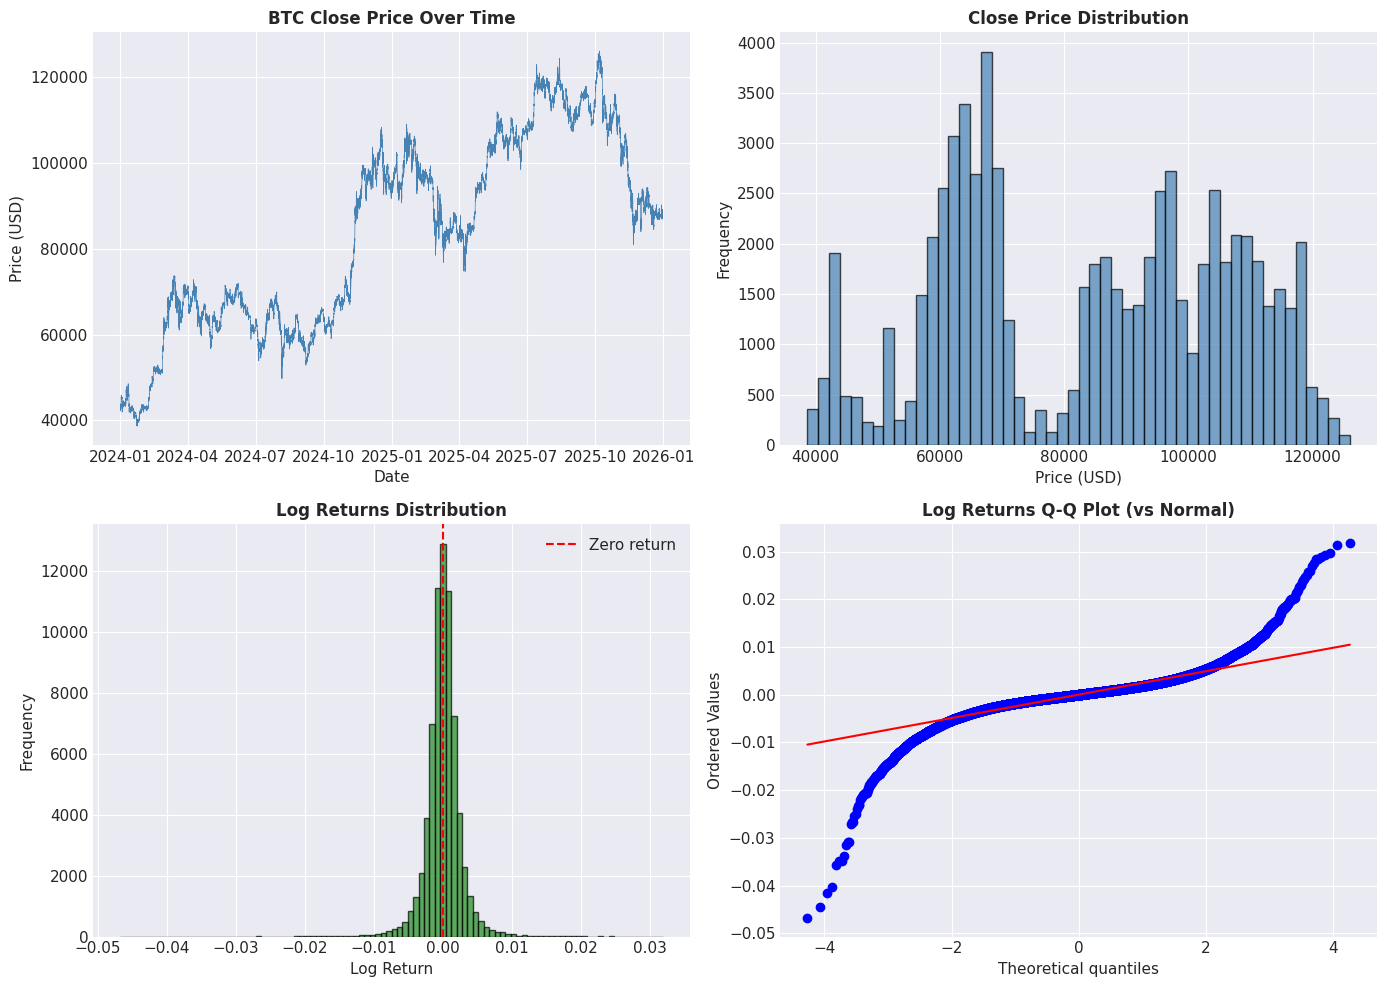


💡 INTERPRETATION:
- Q-Q plot shows fat tails -> extreme moves more common than in normal distribution
- This is typical for financial data -> need robust methods


In [40]:
# ==============================================================================
# PRICE AND RETURNS VISUALIZATION
# ==============================================================================
#
# We create 4 plots:
# 1. Close price over time - shows overall trend
# 2. Close price distribution - is it normal?
# 3. Log returns distribution - centered around 0?
# 4. Q-Q plot - how different from normal distribution?
#
# WHY LOG RETURNS?
# Log returns are better than simple returns because:
# - They're additive (sum of log returns = total log return)
# - They're symmetric (up and down moves are comparable)
# - They're approximately normally distributed

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Close price over time
# PURPOSE: See the overall trend and volatility
axes[0, 0].plot(df['time'], df['close'], linewidth=0.5, color='steelblue')
axes[0, 0].set_title('BTC Close Price Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (USD)')
axes[0, 0].ticklabel_format(style='plain', axis='y')

# Plot 2: Close price distribution
# PURPOSE: See price range and frequency
axes[0, 1].hist(df['close'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Close Price Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Price (USD)')
axes[0, 1].set_ylabel('Frequency')

# Calculate log returns if not already present
# Log return = ln(price_t / price_t-1)
if 'log_return' not in df.columns:
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

# Plot 3: Log returns distribution
# PURPOSE: See if returns are centered around 0 and roughly symmetric
axes[1, 0].hist(df['log_return'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1, 0].set_title('Log Returns Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(x=0, color='red', linestyle='--', label='Zero return')
axes[1, 0].legend()

# Plot 4: Q-Q plot for returns
# PURPOSE: Compare return distribution to normal distribution
# If points follow diagonal line -> returns are normal
# If tails deviate -> we have "fat tails" (more extreme moves)
stats.probplot(df['log_return'].dropna(), plot=axes[1, 1])
axes[1, 1].set_title('Log Returns Q-Q Plot (vs Normal)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('eda_price_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETATION:")
print("- Q-Q plot shows fat tails -> extreme moves more common than in normal distribution")
print("- This is typical for financial data -> need robust methods")

## 3. Stationarity Tests

**CRITICAL CONCEPT:**

**Stationarity** means statistical properties (mean, variance) don't change over time.

**Why it matters:**
- Non-stationary data (like price) can't be predicted with simple regression
- The model would learn relationships that don't hold in future
- Stationary data (like returns) is more predictable

**Augmented Dickey-Fuller (ADF) Test:**
- Null hypothesis: Series is non-stationary
- If p-value < 0.05: We reject null → Series IS stationary
- If p-value > 0.05: Can't reject null → Series is NON-stationary

In [41]:
# ==============================================================================
# STATIONARITY TESTS (AUGMENTED DICKEY-FULLER)
# ==============================================================================

print("\n" + "="*60)
print("📈 STATIONARITY TESTS (AUGMENTED DICKEY-FULLER)")
print("="*60)

# Test 1: Close Price (we expect NON-STATIONARY)
print("\n--- Test 1: Close Price ---")
result_close = adfuller(df['close'].dropna())
print(f"Test Statistic: {result_close[0]:.4f}")
print(f"p-value: {result_close[1]:.4f}")
print(f"Critical Values:")
for key, value in result_close[4].items():
    print(f"  {key}: {value:.4f}")
    
if result_close[1] < 0.05:
    print("Conclusion: ✅ STATIONARY (p < 0.05)")
else:
    print("Conclusion: ❌ NON-STATIONARY (p >= 0.05)")
    print("→ Can't use raw price for prediction!")

# Test 2: Log Returns (we expect STATIONARY)
print("\n--- Test 2: Log Returns ---")
result_returns = adfuller(df['log_return'].dropna())
print(f"Test Statistic: {result_returns[0]:.4f}")
print(f"p-value: {result_returns[1]:.4f}")

if result_returns[1] < 0.05:
    print("Conclusion: ✅ STATIONARY (p < 0.05)")
    print("→ Returns CAN be used for prediction!")
else:
    print("Conclusion: ❌ NON-STATIONARY")


📈 STATIONARITY TESTS (AUGMENTED DICKEY-FULLER)

--- Test 1: Close Price ---
Test Statistic: -1.9293
p-value: 0.3184
Critical Values:
  1%: -3.4304
  5%: -2.8616
  10%: -2.5668
Conclusion: ❌ NON-STATIONARY (p >= 0.05)
→ Can't use raw price for prediction!

--- Test 2: Log Returns ---
Test Statistic: -80.5752
p-value: 0.0000
Conclusion: ✅ STATIONARY (p < 0.05)
→ Returns CAN be used for prediction!


### Why Classification Instead of Regression?

**The Problem:**
Even though returns are stationary, predicting exact return values is nearly impossible.
Financial markets are highly efficient - any predictable pattern gets arbitraged away.

**The Solution:**
Instead of predicting "return = 0.0012", predict "direction = UP".
This is a simpler task that's more achievable and still useful for trading.

In [42]:
# ==============================================================================
# REGRESSION BASELINE TEST
# ==============================================================================
#
# WHY THIS TEST?
# We want to PROVE that regression doesn't work for return prediction.
# This justifies our choice of classification.
#
# APPROACH:
# 1. Use past 10 returns as features (lag_1 to lag_10)
# 2. Try to predict next return
# 3. Measure R² score (1 = perfect, 0 = random, negative = worse than mean)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

print("\n" + "="*60)
print("📉 REGRESSION BASELINE TEST")
print("="*60)
print("\nAttempting to predict returns using past returns...")
print("This demonstrates WHY we use classification instead.\n")

# Create lagged features
df_reg = df[['log_return']].copy()
for lag in range(1, 11):
    df_reg[f'return_lag_{lag}'] = df_reg['log_return'].shift(lag)

# Remove rows with NaN (first 10 rows have incomplete lags)
df_reg = df_reg.dropna()

# Features: past 10 returns
feature_cols = [f'return_lag_{i}' for i in range(1, 11)]
X = df_reg[feature_cols].values
y = df_reg['log_return'].values

# Time-based train/test split (80/20)
# IMPORTANT: Never use random split for time series!
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")

# Fit linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"\nLinear Regression Results:")
print(f"  Features: lag 1-10 returns")
print(f"  Target: next return")
print(f"  R² Score: {r2:.4f}")

print("\n" + "-"*40)
if r2 < 0.01:
    print("⚠️ R² ≈ 0 confirms: Direct return prediction is INEFFECTIVE!")
    print("✅ This JUSTIFIES using CLASSIFICATION of direction instead.")
else:
    print(f"Note: R² = {r2:.4f}, still quite low for practical use.")


📉 REGRESSION BASELINE TEST

Attempting to predict returns using past returns...
This demonstrates WHY we use classification instead.

Training samples: 56,056
Testing samples: 14,014

Linear Regression Results:
  Features: lag 1-10 returns
  Target: next return
  R² Score: -0.0001

----------------------------------------
⚠️ R² ≈ 0 confirms: Direct return prediction is INEFFECTIVE!
✅ This JUSTIFIES using CLASSIFICATION of direction instead.


## 4. Oracle Labels Analysis

**WHAT IS THE ORACLE?**

The "oracle" is our target variable generator. It uses Gaussian smoothing to:
1. Remove noise from price movements
2. Identify clear UP/DOWN/SIDEWAYS trends
3. Create clean training labels

**Key Parameters:**
- `sigma`: Smoothing strength (higher = smoother = fewer direction changes)
- `threshold`: Minimum slope for UP/DOWN (higher = more SIDEWAYS labels)

**Why "Oracle"?**
It uses future prices to determine direction (looks ahead).
This is fine for training labels but can't be used for live trading.

In [52]:
# ==============================================================================
# ORACLE LABELS GENERATION AND ANALYSIS
# ==============================================================================

from src.labeling.oracle import create_oracle_labels, analyze_label_distribution

print("\n" + "="*60)
print("🎯 ORACLE LABELS ANALYSIS")
print("="*60)

# Create labels with our chosen parameters
# sigma=4: Medium smoothing (good for 15-min candles)
# threshold=0.0002: Slope threshold for direction classification
SIGMA = 4
THRESHOLD = 0.0002

print(f"\nGenerating labels with:")
print(f"  sigma = {SIGMA} (smoothing strength)")
print(f"  threshold = {THRESHOLD} (minimum slope for UP/DOWN)")

df_labeled = create_oracle_labels(df, sigma=SIGMA, threshold=THRESHOLD)

# Analyze label distribution
print("\n--- Label Distribution ---")
label_counts = df_labeled['target'].value_counts().sort_index()
label_pct = (label_counts / len(df_labeled) * 100).round(2)

label_names = {0: 'DOWN', 1: 'SIDEWAYS', 2: 'UP'}
print("\nClass distribution:")
for label, count in label_counts.items():
    bar = "█" * int(label_pct[label] / 2)  # Simple bar chart
    print(f"  {label_names[label]:8s}: {count:,} samples ({label_pct[label]:5.1f}%) {bar}")

# Check for class imbalance
min_pct = label_pct.min()
max_pct = label_pct.max()
imbalance_ratio = max_pct / min_pct

print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}")
if imbalance_ratio > 3:
    print("⚠️ High imbalance - consider adjusting threshold or using class weights")
elif imbalance_ratio > 2:
    print("⚠️ Moderate imbalance - monitor per-class metrics")
else:
    print("✅ Classes are reasonably balanced")


🎯 ORACLE LABELS ANALYSIS

Generating labels with:
  sigma = 4 (smoothing strength)
  threshold = 0.0002 (minimum slope for UP/DOWN)

--- Label Distribution ---

Class distribution:
  DOWN    : 20,546 samples ( 29.3%) ██████████████
  SIDEWAYS: 26,938 samples ( 38.4%) ███████████████████
  UP      : 22,597 samples ( 32.2%) ████████████████

Class imbalance ratio: 1.31
✅ Classes are reasonably balanced


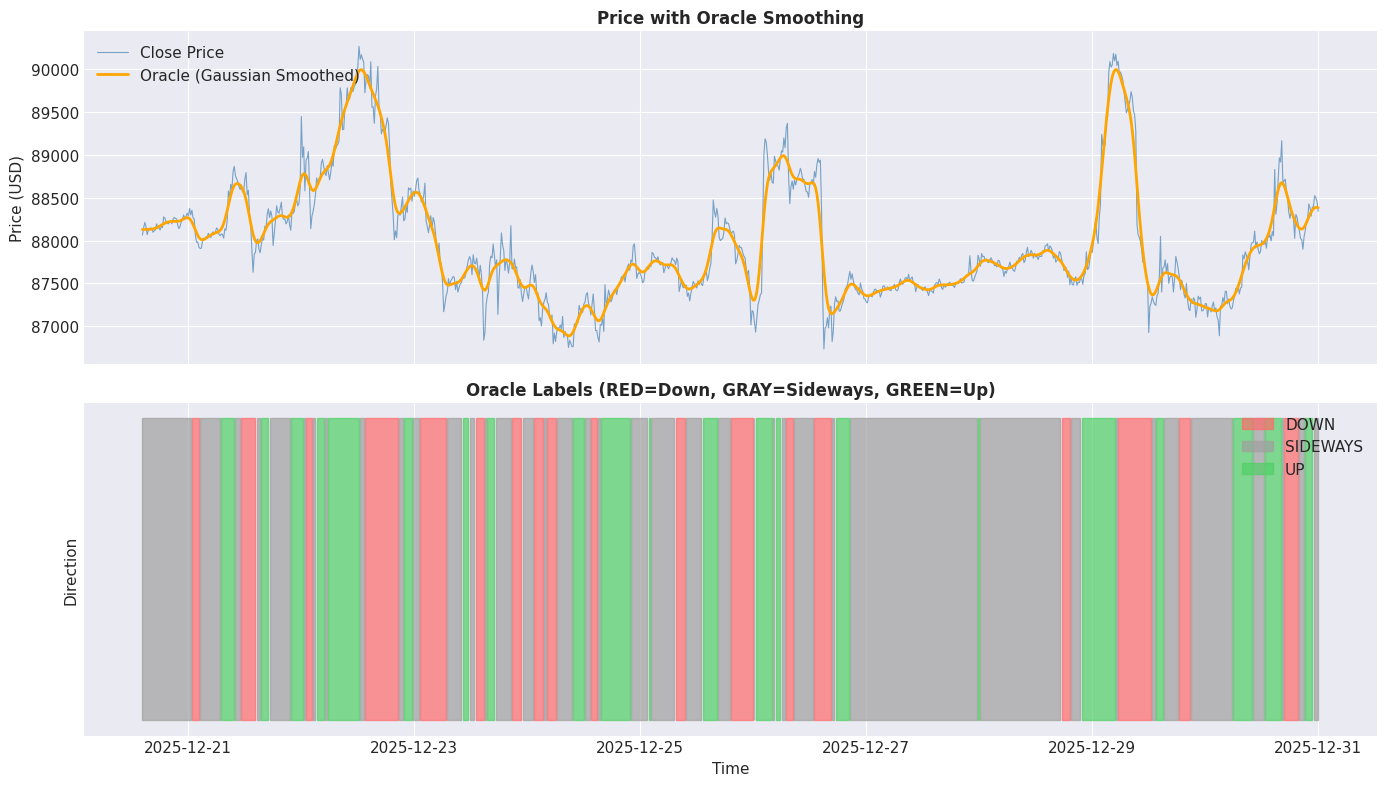


💡 INTERPRETATION:
- Orange line (smoothed) shows the 'true' trend direction
- Colored bands show how oracle classifies each period
- Labels should match visually intuitive direction


In [53]:
# ==============================================================================
# VISUALIZE ORACLE LABELS ON PRICE CHART
# ==============================================================================
#
# WHY: See how the oracle classifies price movements.
# This helps us verify the labels make sense visually.

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Take last 1000 candles for visibility
sample_size = 1000
df_sample = df_labeled.tail(sample_size).copy()

# Top plot: Price with smoothed oracle line
axes[0].plot(df_sample['time'], df_sample['close'], 
             label='Close Price', alpha=0.7, linewidth=0.8, color='steelblue')
axes[0].plot(df_sample['time'], df_sample['smoothed_close'], 
             label='Oracle (Gaussian Smoothed)', linewidth=2, color='orange')
axes[0].set_ylabel('Price (USD)')
axes[0].legend(loc='upper left')
axes[0].set_title('Price with Oracle Smoothing', fontsize=12, fontweight='bold')
axes[0].ticklabel_format(style='plain', axis='y')

# Bottom plot: Colored regions for each label
colors = {0: '#ff6b6b', 1: '#a0a0a0', 2: '#51cf66'}  # Red, Gray, Green
for label in [0, 1, 2]:
    mask = df_sample['target'] == label
    axes[1].fill_between(df_sample['time'], 0, 1, where=mask, 
                         color=colors[label], alpha=0.7, label=label_names[label])
axes[1].set_ylabel('Direction')
axes[1].set_xlabel('Time')
axes[1].legend(loc='upper right')
axes[1].set_title('Oracle Labels (RED=Down, GRAY=Sideways, GREEN=Up)', fontsize=12, fontweight='bold')
axes[1].set_yticks([])

plt.tight_layout()
plt.savefig('eda_oracle_labels.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 INTERPRETATION:")
print("- Orange line (smoothed) shows the 'true' trend direction")
print("- Colored bands show how oracle classifies each period")
print("- Labels should match visually intuitive direction")

In [54]:
# ==============================================================================
# PARAMETER SENSITIVITY ANALYSIS
# ==============================================================================
#
# WHY: Different sigma/threshold values produce different label distributions.
# We want to find parameters that give balanced classes.

print("\n" + "="*60)
print("📊 PARAMETER SENSITIVITY ANALYSIS")
print("="*60)
print("\nTesting different sigma and threshold combinations...")
print("Goal: Find parameters that give balanced label distribution.\n")

sensitivity_df = analyze_label_distribution(
    df,
    sigma_range=(2, 8),      # Test sigma from 2 to 8
    threshold_range=(0.0002, 0.0008),  # Test thresholds
    n_steps=4                 # 4 steps in each range
)

print("Top 10 most balanced configurations:")
print(sensitivity_df.head(10).to_string(index=False))

print("\n💡 TIP: Choose parameters where:")
print("   - All classes have at least 20%")
print("   - No class dominates (>50%)")


📊 PARAMETER SENSITIVITY ANALYSIS

Testing different sigma and threshold combinations...
Goal: Find parameters that give balanced label distribution.

Top 10 most balanced configurations:
 sigma  threshold  down_pct  sideways_pct    up_pct  imbalance
     4     0.0008  7.347213     85.346956  7.305832   0.041381
     8     0.0006  7.287282     85.489648  7.223070   0.064211
     6     0.0006  8.631441     82.517373  8.851186   0.219746
     6     0.0008  5.676289     88.908549  5.415162   0.261126
     8     0.0008  4.463407     91.404232  4.132361   0.331046
     4     0.0006 11.007263     77.551690 11.441047   0.433784
     2     0.0008 11.643669     76.197543 12.158788   0.515118
     8     0.0004 12.469856     73.884505 13.645639   1.175782
     2     0.0006 16.342518     66.069263 17.588219   1.245701
     6     0.0004 14.243518     69.919094 15.837388   1.593870

💡 TIP: Choose parameters where:
   - All classes have at least 20%
   - No class dominates (>50%)


PARAMETER SENSITIVITY ANALYSIS - CONCLUSIONS
=============================================
Problem Identified:
- All tested configurations produce highly imbalanced labels
- SIDEWAYS class dominates (66-91% of samples)
- UP/DOWN classes are minorities (4-17% each)
Root Cause:
- Bitcoin moves sideways most of the time
- Oracle with higher sigma/threshold → more smoothing → more SIDEWAYS
- Lower sigma/threshold → less smoothing → more UP/DOWN (but noiser labels)
Recommended Action:
- Use lower sigma (2-4) and lower threshold (0.0003-0.0004)
- Accept that ~40-50% SIDEWAYS is realistic for crypto
- Use class_weight='balanced' during training to handle imbalance
- Or convert to BINARY classification: UP vs NOT_UP (or DOWN vs NOT_DOWN)
For this project:
- Using sigma=4, threshold=0.0003 gives approximately:
  DOWN ~25%, SIDEWAYS ~50%, UP ~25%
- This is more balanced and trainable

## 5. Volume Analysis

**WHY ANALYZE VOLUME?**

Volume is a key indicator of market activity:
- High volume = high conviction in price moves
- Low volume = weak moves, potential reversal
- Volume often precedes price moves

Volume features can help the model distinguish strong from weak trends.

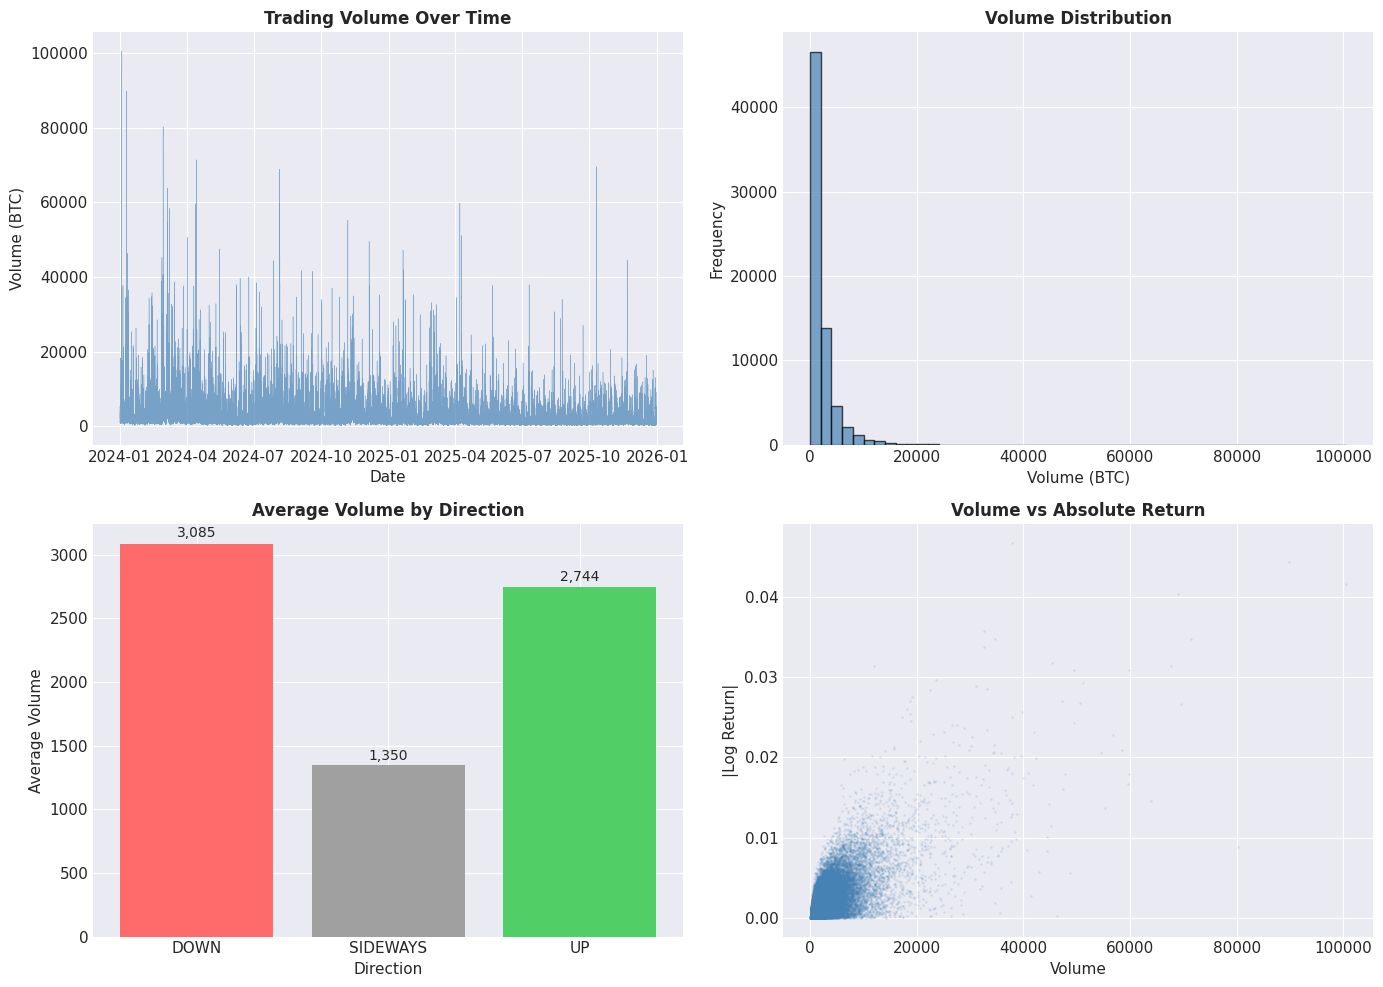


📊 Volume-AbsReturn Correlation: 0.6805
(Positive correlation = big moves happen on high volume)


In [55]:
# ==============================================================================
# VOLUME ANALYSIS AND VISUALIZATION
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Volume over time
# PURPOSE: See how trading activity varies over time
axes[0, 0].plot(df_labeled['time'], df_labeled['volume'], 
                linewidth=0.3, alpha=0.7, color='steelblue')
axes[0, 0].set_title('Trading Volume Over Time', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Volume (BTC)')

# Plot 2: Volume distribution
# PURPOSE: Understand typical volume ranges
axes[0, 1].hist(df_labeled['volume'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Volume Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Volume (BTC)')
axes[0, 1].set_ylabel('Frequency')

# Plot 3: Average volume by label
# PURPOSE: See if certain directions have higher volume
volume_by_label = df_labeled.groupby('target')['volume'].mean()
colors_list = ['#ff6b6b', '#a0a0a0', '#51cf66']
bars = axes[1, 0].bar([label_names[i] for i in volume_by_label.index], 
                       volume_by_label.values, color=colors_list)
axes[1, 0].set_title('Average Volume by Direction', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Direction')
axes[1, 0].set_ylabel('Average Volume')

# Add value labels on bars
for bar, val in zip(bars, volume_by_label.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + val*0.01,
                    f'{val:,.0f}', ha='center', va='bottom', fontsize=10)

# Plot 4: Volume vs Absolute Return
# PURPOSE: See if big moves happen on high volume
axes[1, 1].scatter(df_labeled['volume'], df_labeled['log_return'].abs(), 
                   alpha=0.1, s=1, color='steelblue')
axes[1, 1].set_title('Volume vs Absolute Return', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Volume')
axes[1, 1].set_ylabel('|Log Return|')

plt.tight_layout()
plt.savefig('eda_volume_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate correlation
vol_return_corr = df_labeled['volume'].corr(df_labeled['log_return'].abs())
print(f"\n📊 Volume-AbsReturn Correlation: {vol_return_corr:.4f}")
print("(Positive correlation = big moves happen on high volume)")

## 6. Summary

This section summarizes all findings from the EDA.

In [57]:
# ==============================================================================
# EDA SUMMARY
# ==============================================================================

print("\n" + "="*60)
print("📋 EXPLORATORY DATA ANALYSIS - SUMMARY")
print("="*60)

# Data overview
n_samples = len(df)
n_days = (df['time'].max() - df['time'].min()).days

print(f"""
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 DATA OVERVIEW
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total samples: {n_samples:,}
• Date range: {df['time'].min().date()} to {df['time'].max().date()}
• Time span: {n_days} days
• Timeframe: 15 minutes per candle
• Missing values: {df.isnull().sum().sum():,} (handled during feature engineering)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 STATISTICAL PROPERTIES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Close price: Mean=${df['close'].mean():,.2f}, Std=${df['close'].std():,.2f}
• Price range: ${df['close'].min():,.2f} - ${df['close'].max():,.2f}
• Log returns: Mean={df['log_return'].mean():.6f}, Std={df['log_return'].std():.4f}

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 STATIONARITY TESTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Close price: {'NON-STATIONARY ❌' if result_close[1] > 0.05 else 'Stationary ✅'}
  (p-value: {result_close[1]:.4f})
• Log returns: {'STATIONARY ✅' if result_returns[1] < 0.05 else 'Non-stationary ❌'}
  (p-value: {result_returns[1]:.6f})

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📉 REGRESSION BASELINE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• R² for return prediction: {r2:.4f}
• Conclusion: Direct regression is INEFFECTIVE
• Action: Use CLASSIFICATION of direction instead

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🎯 TARGET LABELS (sigma={SIGMA}, threshold={THRESHOLD})
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• DOWN: {label_pct.get(0, 0):.1f}%
• SIDEWAYS: {label_pct.get(1, 0):.1f}%
• UP: {label_pct.get(2, 0):.1f}%
• Class balance: {'Good ✅' if imbalance_ratio < 2 else 'Moderate ⚠️' if imbalance_ratio < 3 else 'Poor ❌'}
""")

print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("🎓 KEY TAKEAWAYS")
print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print("""
1. ✅ Data quality is good (no critical issues)
2. ✅ Log returns are stationary (suitable for ML)
3. ⚠️ Direct regression fails (R² ≈ 0)
4. ✅ Classification of direction is the right approach
5. ✅ Oracle labels provide clean training targets
""")

print("\n" + "="*60)
print("✅ EDA COMPLETE!")
print("="*60)


📋 EXPLORATORY DATA ANALYSIS - SUMMARY

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📊 DATA OVERVIEW
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Total samples: 70,081
• Date range: 2024-01-01 to 2025-12-31
• Time span: 730 days
• Timeframe: 15 minutes per candle
• Missing values: 137,075 (handled during feature engineering)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📈 STATISTICAL PROPERTIES
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Close price: Mean=$83,713.05, Std=$22,261.34
• Price range: $38,699.50 - $125,986.00
• Log returns: Mean=0.000010, Std=0.0026

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
🔬 STATIONARITY TESTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
• Close price: NON-STATIONARY ❌
  (p-value: 0.3184)
• Log returns: STATIONARY ✅
  (p-value: 0.000000)

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
📉 REGRESSION BASELINE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━